In [0]:
import pandas as pd
import numpy as np
from google.colab import files
import string
import io
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
import math
import re
import seaborn as sns
from copy import copy, deepcopy
from unicodedata import normalize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from numpy import asarray

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
file = open('drive/My Drive/spa.txt').read().split('\n')
lines = file[0:7500]
print(len(lines))
print(lines[100])

7500
Go away!	¡Vete de aquí!


In [0]:
def My_train_test_split(df,df2,train_percent, test_percent):
    # calculate random permutation of indices
    m = len(df)
    perm = np.random.permutation(m)
    train_end = int(train_percent * m)
    test_end = int(test_percent * m) + train_end
    
    Xtrain = [df[i] for i in perm[:train_end]]
    Xtest = [df[i] for i in perm[train_end:test_end]]
    
    Ytrain = [df2[i] for i in perm[:train_end]]
    Ytest = [df2[i] for i in perm[train_end:test_end]]
    return(Xtrain, Xtest, Ytrain,Ytest,)  
  
def clean_pairs(lines):
  cleaned = list()
  # prepare regex for char filtering
  re_print = re.compile('[^%s]' % re.escape(string.printable))
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for pair in lines:
    clean_pair = list()
    for line in pair:
      # rmove word characters.
      line = normalize('NFD', line).encode('ascii', 'ignore')
      line = line.decode('UTF-8')
      # tokenize on white space
      line = line.split()
      # convert to lowercase
      line = [word.lower() for word in line]
      # remove punctuation from each token
      line = [word.translate(table) for word in line]
      # remove non-printable chars form each token
      line = [w.strip() for w in line]
      # remove tokens with numbers in them
      line = [word for word in line if word.isalpha()]
      # store as string
      clean_pair.append(' '.join(line))
    cleaned.append(clean_pair)
  return(cleaned)

split = [re.split(r'\t+', item)for item in lines]
split = clean_pairs(split)
X  = [x[0] for x in split]
# add both start and end tokens to denote the end
#of the sentence to the each target line.
Y  = ['START_ ' + x[1] + ' _END'for x in split]

df = pd.DataFrame(
    {'X': X,
     'Y': Y,
    })

# remove duplicates
df = df.drop_duplicates(subset=['X'], keep= 'first')
X = df.X.values
X  = [x.split() for x in X]
Y = df.Y.values
Y  = [y.split() for y in Y]

# split into train an test.
Xtrain,Xtest,Ytrain,Ytest = My_train_test_split(X,Y,0.7, 0.3)

In [0]:
# set of english words 
all_eng_words  = set([item for sublist in X for item in sublist])
# set of spanish words 
all_spa_words = set([item for sublist in Y for item in sublist])

# maximum english sentence length
eng_sentence_length = max([len(sample.split()) for sample in df.X])
# maximum spanish  sentence length
spa_sentence_length = max([len(sample.split()) for sample in df.Y])

input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_spa_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_spa_words)

In [0]:
print('Number of samples:', len(df))
print('Number of unique source language tokens:', len(all_eng_words))
print('Number of unique target language tokens:', len(all_spa_words))
print('Max sequence length of source language:', eng_sentence_length)
print('Max sequence length of target language:', spa_sentence_length)
print("Source Vocabulary",all_eng_words)
print("Target Vocabulary",all_spa_words)

Number of samples: 5308
Number of unique source language tokens: 1881
Number of unique target language tokens: 2936
Max sequence length of source language: 5
Max sequence length of target language: 10
Source Vocabulary {'watch', 'bossy', 'offer', 'harm', 'fascinated', 'are', 'furious', 'knits', 'tough', 'father', 'tempt', 'ate', 'feast', 'usually', 'approached', 'refuse', 'baking', 'lips', 'italian', 'cheered', 'remember', 'lift', 'awkward', 'clever', 'met', 'popular', 'bores', 'rush', 'rested', 'quickly', 'healthy', 'sequel', 'driving', 'blew', 'ears', 'mess', 'ashamed', 'another', 'cheat', 'breath', 'skating', 'so', 'arent', 'your', 'blushed', 'curious', 'relieved', 'warm', 'dressed', 'drinks', 'vigilant', 'rude', 'brace', 'possible', 'feed', 'movies', 'groggy', 'isnt', 'youre', 'deserted', 'slacker', 'humor', 'anyway', 'farmer', 'trust', 'disgusting', 'annoy', 'insult', 'something', 'student', 'anybody', 'whens', 'hoot', 'slept', 'kidding', 'cant', 'wonderful', 'stubborn', 'drink', 

In [0]:
# dictionary of words whereeach value is a unique integer value
input_token_index = dict(
    [(word, i) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i) for i, word in enumerate(target_words)])

# placeholders training data
encoder_input_data = np.zeros(
    (len(Xtrain), eng_sentence_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(Ytrain), spa_sentence_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(Ytrain), spa_sentence_length, num_decoder_tokens),
    dtype='float32')

# populate all the placeholders with unique integer values for every word
for i, (input_text, target_text) in enumerate(zip(Xtrain, Ytrain)):
    for t, word in enumerate(input_text):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

# load the Glove file create an index for each word in
# embedding file that represents the embeding vector
embeddings_index = dict()
f = open('drive/My Drive/glove.6B.100d.txt').readlines()
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs

# create an embedding vector for each value in our unique
# source language.
MAX_NUM_WORDS = 1880
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(all_eng_words)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for i, word in enumerate(list(all_eng_words)):
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
encoder_input_data[3]

array([ 858.,  857., 1032.,    0.,    0.], dtype=float32)

In [0]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.utils import plot_model

embedding_size = 100
encoder_inputs = Input(shape=(None,))
en_x = Embedding(num_encoder_tokens, embedding_size, weights= [embedding_matrix], trainable=False)(encoder_inputs)
encoder = LSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder(en_x)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
dex=  Embedding(num_decoder_tokens, embedding_size)
final_dex= dex(decoder_inputs)
decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(final_dex,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    188100      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    293600      input_2[0][0]                    
_____________________________________

In [0]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=100,
          validation_split=0.05)

Train on 3529 samples, validate on 186 samples
Epoch 1/100
3529/3529 [==============================] - 6s 2ms/step - loss: 0.8596 - acc: 0.2038 - val_loss: 1.5614 - val_acc: 0.1581
Epoch 2/100
3529/3529 [==============================] - 7s 2ms/step - loss: 0.8498 - acc: 0.2055 - val_loss: 1.5661 - val_acc: 0.1543
Epoch 3/100
3529/3529 [==============================] - 6s 2ms/step - loss: 0.8403 - acc: 0.2068 - val_loss: 1.5681 - val_acc: 0.1548
Epoch 4/100
3529/3529 [==============================] - 6s 2ms/step - loss: 0.8303 - acc: 0.2078 - val_loss: 1.5713 - val_acc: 0.1575
Epoch 5/100
3529/3529 [==============================] - 6s 2ms/step - loss: 0.8211 - acc: 0.2092 - val_loss: 1.5717 - val_acc: 0.1548
Epoch 6/100
3529/3529 [==============================] - 6s 2ms/step - loss: 0.8113 - acc: 0.2104 - val_loss: 1.5764 - val_acc: 0.1548
Epoch 7/100
3529/3529 [==============================] - 6s 2ms/step - loss: 0.8034 - acc: 0.2124 - val_loss: 1.5713 - val_acc: 0.1575
Epoch 8/

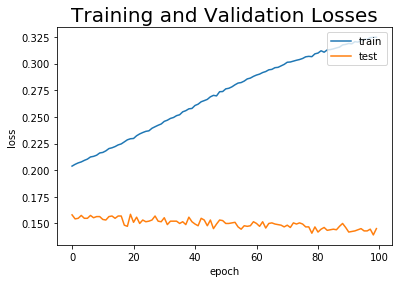

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and Validation Accuracy',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(50,))
decoder_state_input_c = Input(shape=(50,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

final_dex2= dex(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 52):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
        
    return decoded_sentence

# Create placeholder variables for our test embeddings
encoder_input_data_test = np.zeros(
    (len(Xtest), eng_sentence_length),
    dtype='float32')
decoder_input_data_test = np.zeros(
    (len(Ytest), spa_sentence_length),
    dtype='float32')
decoder_target_data_test = np.zeros(
    (len(Ytest), spa_sentence_length, num_decoder_tokens),
    dtype='float32')

# populate the test place holders
for i, (input_text, target_text) in enumerate(zip(Xtest, Ytest)):
    for t, word in enumerate(input_text):
        encoder_input_data_test[i, t] = input_token_index[word]
    for t, word in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data_test[i, t] = target_token_index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data_test[i, t - 1, target_token_index[word]] = 1.

In [0]:
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

# using the sentence_bleu score from nltk
# find the average smoothend Bleu score for the entire test set.
#Smooth = SmoothingFunction().method1
bleu_score = []
for i in range(len(Ytest)):
  input_seq = encoder_input_data_test[i: i + 1]
  decoded_sentence = decode_sequence(input_seq)
  #decoded_sentence
  reference = Ytest[i][1:-1]
  decoded_sentence = decoded_sentence.split()
  del decoded_sentence[-1]
  bleu_score.append(sentence_bleu([reference],decoded_sentence,weights=(0.25, 0.25, 0.25, 0.25)))


print('Average BLEU Score is: ' + str(np.mean(bleu_score)))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average BLEU Score is: 0.4206513423770374


# Section 2 Attention

---



In [0]:
from keras.layers import SimpleRNN
from keras.layers import Activation, dot, concatenate
from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense

embedding_size = 100
Encoder_Input = Input(shape=(eng_sentence_length,))
encoder = Embedding(num_encoder_tokens, embedding_size, weights= [embedding_matrix], trainable=False)(Encoder_Input)
encoder = LSTM(64, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

Decoder_Input = Input(shape=(spa_sentence_length,))
decoder = Embedding(num_decoder_tokens, embedding_size)(Decoder_Input)
decoder = LSTM(64, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

# Global Attention with Dot-based scoring function 
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)

context = dot([attention, encoder], axes=[2,1])

decoder_combined_context = concatenate([context, decoder])

output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(num_decoder_tokens, activation="softmax"))(output)

model = Model(inputs =[Encoder_Input, Decoder_Input], outputs =[output])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 10, 100)      293600      input_6[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 5, 100)       188100      input_5[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LS

In [0]:
history = model.fit([encoder_input_data, decoder_input_data],
          [decoder_target_data] ,verbose=2, batch_size=128,
          epochs=100, validation_split=0.05)

Train on 3529 samples, validate on 186 samples
Epoch 1/100
 - 9s - loss: 2.4655 - acc: 0.0940 - val_loss: 2.0983 - val_acc: 0.1000
Epoch 2/100
 - 5s - loss: 2.0299 - acc: 0.1000 - val_loss: 1.9739 - val_acc: 0.1000
Epoch 3/100
 - 6s - loss: 1.9570 - acc: 0.1000 - val_loss: 1.9717 - val_acc: 0.1000
Epoch 4/100
 - 5s - loss: 1.9210 - acc: 0.1000 - val_loss: 1.9561 - val_acc: 0.1000
Epoch 5/100
 - 5s - loss: 1.8756 - acc: 0.1000 - val_loss: 1.9322 - val_acc: 0.1000
Epoch 6/100
 - 5s - loss: 1.8285 - acc: 0.1034 - val_loss: 1.9200 - val_acc: 0.1016
Epoch 7/100
 - 5s - loss: 1.7870 - acc: 0.1103 - val_loss: 1.8987 - val_acc: 0.1108
Epoch 8/100
 - 5s - loss: 1.7407 - acc: 0.1149 - val_loss: 1.8671 - val_acc: 0.1134
Epoch 9/100
 - 5s - loss: 1.7005 - acc: 0.1180 - val_loss: 1.8452 - val_acc: 0.1129
Epoch 10/100
 - 5s - loss: 1.6642 - acc: 0.1192 - val_loss: 1.8249 - val_acc: 0.1199
Epoch 11/100
 - 5s - loss: 1.6319 - acc: 0.1244 - val_loss: 1.8159 - val_acc: 0.1226
Epoch 12/100
 - 5s - loss: 

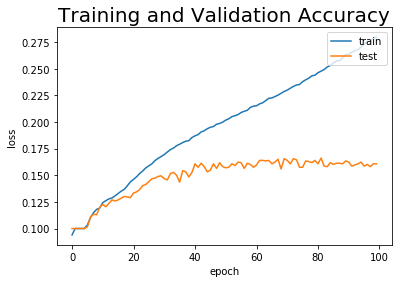

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and Validation Accuracy',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
def encode(text):
  # predict an encoded vector for our target language
  # given an encoded vetor for our source language.
  decoder_input = np.zeros(shape=(eng_sentence_length, spa_sentence_length))
  decoder_input[:,0] = target_token_index['START_']
  for i in range(1, spa_sentence_length):
    output_ = model.predict([text, decoder_input]).argmax(axis=2)
    decoder_input[:,i] = output_[:,i]
  return decoder_input[:,1:]

def decode(sequence):
  # decode an encoded vector using the reverse dictionary
  # created earlier.
  text = ''
  for i in sequence:
    if reverse_target_char_index[i] == '_END':
      break
    else:
      text += ' ' + reverse_target_char_index[i]
  return text

def Translate(text):
  # tranalate a given encoded vector into a target langauage
  decoder_output = encode(text)
  return decode(decoder_output[0]).split()


#Smooth = SmoothingFunction().method2
bleu_score = []
for i in range(len(Ytest)):
  # using the sentence_bleu score from nltk
  # find the average smoothend Bleu score for the entire test set.
  input_seq = encoder_input_data_test[i: i + 1]
  decoded_sentence = Translate(input_seq)
  #decoded_sentence
  reference = Ytest[i][1:-1]
  bleu_score.append(sentence_bleu([reference],decoded_sentence ,weights=(0.25, 0.25, 0.25, 0.25)))

print('Average BLEU Score is: ' + str(np.mean(bleu_score)))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average BLEU Score is: 0.37426127114948826


# References.

* https://nextjournal.com/gkoehler/machine-translation-seq2seq-cpu?fbclid=IwAR2t0Ie4r68vPKvU-YHtWfkgJC7dmPSsbZCefwAW8aQe4RnE8qoCEYxGfoU
* https://arxiv.org/pdf/1508.04025.pdf
* https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

